# Image Denoising Filters
*Gaussian, Median, and Non-Local Means Denoising Explained*

---

## Introduction

In practice, microscopists often face a trade-off between:
- **Imaging speed**
- **Signal-to-noise ratio (SNR)**

While publication-quality images are ideal, many workflows only require **sufficient image quality** to extract quantitative information such as:
- Distribution of mitochondria or nuclei
- Inclusion bodies
- Mineral phases in material or geological samples

If the same information can be extracted from **lower SNR images**, faster acquisition is often the better choice. As a result, **noise is unavoidable**, and learning how to handle it is essential.

---


## What Is Image Denoising?

Digital image denoising is fundamentally based on **convolution**.

### Convolution in Simple Terms

- An image is a large matrix of numbers
- A **kernel** (or filter) is a small matrix (e.g., 3×3 or 5×5)
- Convolution slides the kernel across the image and combines values locally

Depending on the kernel, convolution can:
- Smooth noise
- Preserve or blur edges
- Enhance or suppress features

---

## Linear vs Non-Linear Filters

### Linear Filters
- Use weighted averaging
- Example: **Gaussian filter**
- Tend to blur noise *and* edges

### Non-Linear Filters
- Use rank-based or pattern-based operations
- Example: **Median filter**, **Non-Local Means**
- Often preserve edges better

In this notebook, we examine three filters:
1. Gaussian filter
2. Median filter
3. Non-Local Means (NLM) denoising

---

## Gaussian Kernel: Conceptual Overview

A **Gaussian kernel** is a 2D bell-shaped surface:
- Highest weight at the center
- Weights decrease smoothly toward the edges
- All values sum to **1**, preserving image energy

Visually, think of it as a smooth hill:
- Central pixel contributes most
- Neighbors contribute less as distance increases

Bell-shaped kernel:
<img src="gaussianKernel1.jpg" alt="Gaussian Kernel" style="display: block; margin: auto;"/>

How kernel works: 
<img src="gaussianKernel2.jpg" alt="Gaussian Kernel" style="display: block; margin: auto;" width = 400/>

---

## Example Image

We use a **fluorescence microscopy image** with substantial noise:
- High background fluctuations
- Important edges (e.g., nuclei boundaries) must be preserved

---

### Read the Image

In [1]:
from skimage import io

img = io.imread("fluorescenceImage.jpg")

### Gaussian Denoising (SciPy)

Gaussian filtering is available in `scipy.ndimage`.

In [28]:
from scipy import ndimage

gaussian_image = ndimage.gaussian_filter(img, sigma=1)

You can see how the sigma value affect the kernel:   

<img src="gaussianKernel1.jpg" alt="Gaussian Kernel" style="display: block; margin: auto;"/>


Now let's see the results:

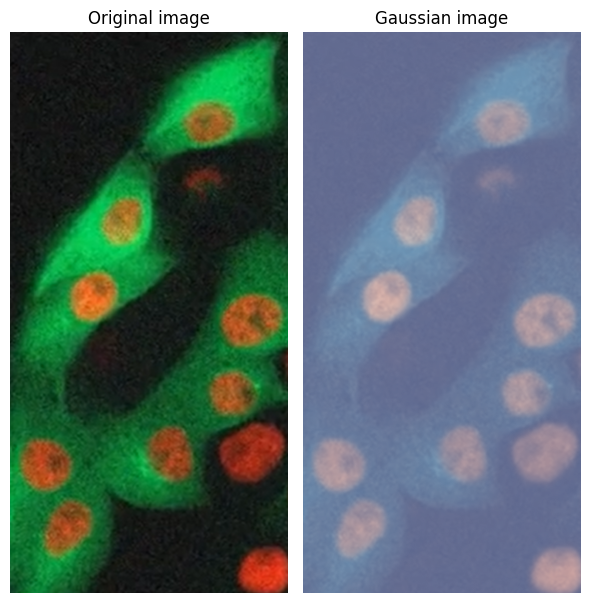

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 7))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(gaussian_image)
plt.axis("off")
plt.title("Gaussian image")


plt.tight_layout()
plt.show()

Observation:

- Noise is significantly reduced
- Edges are blurred
- Fine structural details are lost

👉 Gaussian filtering is often not ideal for microscopy segmentation tasks.

---

### Median Filtering

The median filter replaces each pixel with the median value in a local window.

Key Properties
- Non-linear filter
- Preserves edges well
- Excellent for salt-and-pepper and shot noise

#### Apply Median Filter

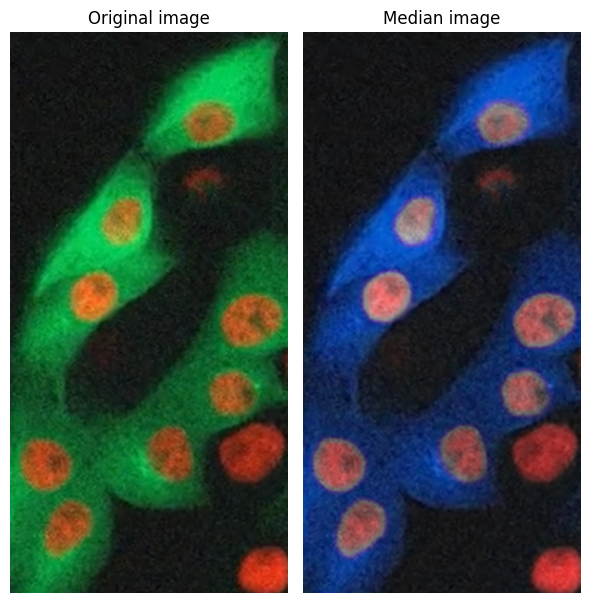

In [17]:
median_image = ndimage.median_filter(img, size=3)

plt.figure(figsize=(6, 7))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(median_image)
plt.axis("off")
plt.title("Median image")


plt.tight_layout()
plt.show()

#### Increasing Kernel Size

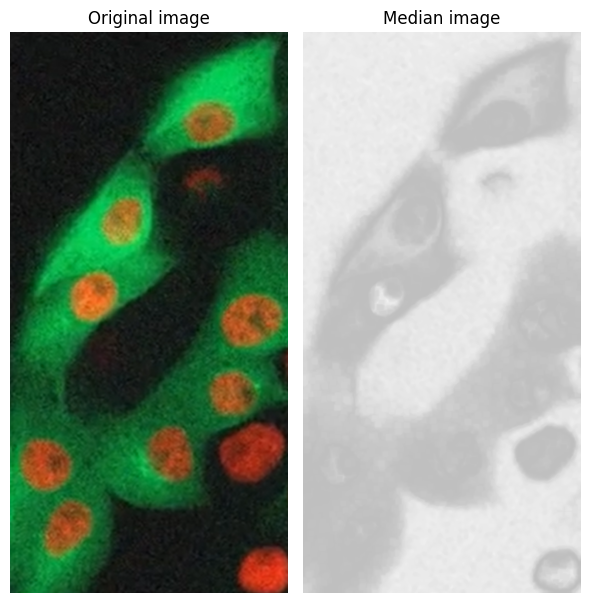

In [18]:
median_image = ndimage.median_filter(img, size=8)

plt.figure(figsize=(6, 7))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(median_image)
plt.axis("off")
plt.title("Median image")


plt.tight_layout()
plt.show()

Observation:

Kernel size 3×3:
- Excellent noise reduction
- Edges preserved

Kernel size 8×8:
- Slight edge degradation
- Minimal improvement over 3×3

👉 3×3 median filtering is often a strong default choice.

---

### Non-Local Means (NLM) Denoising

#### Why Non-Local Means?

Unlike local filters, Non-Local Means:
- Searches for similar patches across the entire image
- Averages pixels based on pattern similarity, not proximity
- Preserves textures and edges extremely well

This makes NLM ideal for:
- Fluorescence microscopy
- Electron microscopy
- CT images
- High-ISO camera images

#### Required Functions

In [19]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_float
import numpy as np

#### Convert Image to Float

In [20]:
img_float = img_as_float(img)

#### Estimate Noise Level

In [23]:
sigma_est = np.mean(estimate_sigma(img_float, channel_axis=-1))
print(sigma_est)

0.0011566523758227802


#### Apply Non-Local Means

In [42]:
nlm_image = denoise_nl_means(
    img_float,
    h=25 * sigma_est,      # ← stronger denoising
    patch_size=5,
    patch_distance=7,       # ← larger search window
    channel_axis=-1,        # ← CRITICAL FIX
    fast_mode=True
)

Why `fast_mode=True`?
- Up to 10× faster
- Minimal difference in output quality
- Highly recommended for batch processing

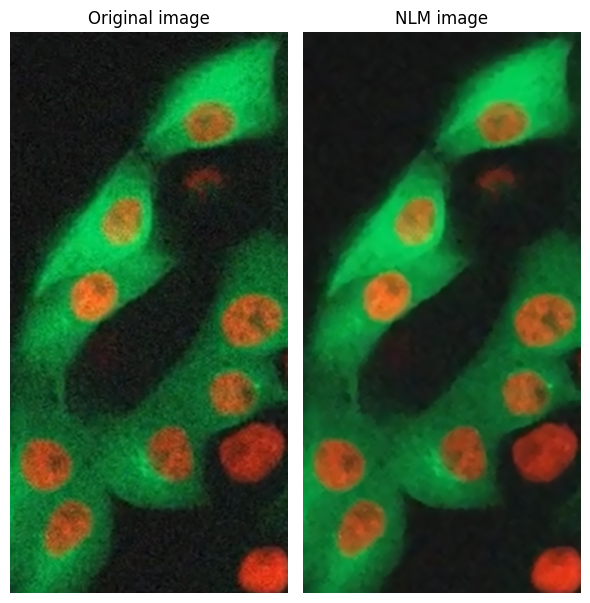

In [43]:
plt.figure(figsize=(6, 7))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(nlm_image)
plt.axis("off")
plt.title("NLM image")


plt.tight_layout()
plt.show()

#### Comparison Summary

| Filter          | Noise Reduction | Edge Preservation | Speed                        |
| --------------- | --------------- | ----------------- | ---------------------------- |
| Gaussian        | Good            | Poor              | Fast                         |
| Median (3×3)    | Good            | Good              | Fast                         |
| Non-Local Means | Excellent       | Excellent         | Slower (but fast_mode helps) |

**Key Takeaways**
- Gaussian filtering smooths aggressively but destroys edges
- Median filtering is a strong, simple edge-preserving filter
- Non-Local Means is the most powerful denoising method here
- Convert images to float before advanced denoising
- Use fast_mode=True for practical workflows
> After NLM denoising, images are often ready for segmentation without additional preprocessing.